In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn 
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from torchvision import transforms

use_cuda = False
os.environ["CUDA_VISIBLE_DEVICES"]="7"
if torch.cuda.is_available():
    device = torch.cuda.device("cuda:7")
    use_cuda = True

In [2]:
class ExpLinear(nn.Module):
    def __init__(self, in_size):
        super(ExpLinear, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_size, 1))
        self.alpha = nn.Sequential(nn.Linear(1, 1, bias=False))
        def prnt(args):
            #print ("grad: ", args)
            #print ("val: ", self.cloned_x)
            pass
        dict(self.alpha.named_parameters())['0.weight'].register_hook(prnt)
        self.cloned_x = None

    def forward(self, x):
        self.cloned_x = self.alpha(torch.exp(self.linear(x))).clone().detach()
        return self.alpha(torch.exp(self.linear(x)))
    
    def get_alpha(self):
        return get_pure(dict(self.alpha.named_parameters())['0.weight'])[0][0]
    
    def init_weigth(self, mean, std):
        for name, param in super(ExpLinear, self).named_parameters():
            param.data.normal_(mean, std)

In [3]:
class Classifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_size):
        super(Classifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [5]:
class TwoCircleDataset(Dataset):
    def __init__(self, R1, R2, N, dim, train=False, normalize=True):
        self.R1 = R1
        self.R2 = R2
        self.N = N
        self.dim = dim
        self.train = train
        self.normalize = normalize
        
#         self.dots = torch.zeros([N + N // 2, dim])
        
#         self.classes = torch.zeros([N + N // 2])        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        for idx in range(self.N):
            self.dots[idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
            self.dots[idx] /= torch.sqrt(torch.sum(self.dots[idx] ** 2))
            self.classes[idx] = self.classes[idx]
            if self.classes[idx] == 1:
                self.dots[idx] *= self.R1
            else:
                self.dots[idx] *= self.R2
                
#         for idx in range(self.N // 2):
#             self.dots[N + idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
#             self.dots[N + idx] /= torch.sqrt(torch.sum(self.dots[N + idx] ** 2))
#             if self.R1 > self.R2:
#                 self.classes[N + idx] = 1
#                 self.dots[idx] *= self.R1 * 2
#             else:
#                 self.classes[N + idx] = -1
#                 self.dots[idx] *= self.R2 * 2
                
        self.mean = self.dots.mean(dim=0)
        self.std = self.dots.std(dim=0)
        
        if self.normalize:
            self.dots = (self.dots - self.mean.expand_as(self.dots)) / self.std.expand_as(self.dots)
                
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [6]:
class TwoGaussiansDataset(Dataset):
    def __init__(self, M1, M2, N, dim, train=False):
        self.M1 = M1
        self.M2 = M2
        self.N = N
        self.dim = dim
        self.train = train
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator_1 = torch.distributions.normal.Normal(torch.tensor([M1]), torch.tensor([1.0]))
        self.normal_generator_2 = torch.distributions.normal.Normal(torch.tensor([M2]), torch.tensor([1.0]))
        for idx in range(self.N):
            if self.classes[idx] == 1:
                self.dots[idx] = self.normal_generator_1.sample_n(self.dim).view(1, -1)
            else:
                self.dots[idx] = self.normal_generator_2.sample_n(self.dim).view(1, -1)
        
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])

In [7]:
dataset_c_train = TwoCircleDataset(1, 10, 1000, 100, train=True)
dataset_c_test = TwoCircleDataset(1, 10, 1000, 100, train=False)
dataset_c_validation = TwoCircleDataset(1, 10, 1000, 100, train=False)
dataloader_c_train = DataLoader(dataset_c_train, batch_size=128, shuffle=True)
dataloader_c_test = DataLoader(dataset_c_test, batch_size=128, shuffle=True)

dataset_g_train = TwoGaussiansDataset(0., 0.1, 2000, 100, train=True)
dataset_g_test = TwoGaussiansDataset(0., 0., 2000, 100, train=False)
dataset_g_validation = TwoGaussiansDataset(0., 0.1, 2000, 100, train=False)
dataloader_g_train = DataLoader(dataset_g_train, batch_size=128, shuffle=True)
dataloader_g_test = DataLoader(dataset_g_test, batch_size=128, shuffle=True)

In [8]:
def get_pure(args):
    return args.data.cpu().clone().numpy()

In [9]:
def train_WITH_EXP(network, learning_rate, reg_lambda, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        reg_loss = None
        for param in network.explinear.alpha.parameters():
            reg_loss = reg_lambda * param.norm(2)
        return loss + reg_loss, reg_loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    alpha = []    
    reg_losses = []
    try:
        for epoch in range(epochs):
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            alpha.append(network.get_alpha())
            
            loss, reg_loss = loss_func(network(dataloader_train.dataset.dots),
                                       dataloader_train.dataset.classes, network,
                                       reg_lambda)
            losses_train.append(get_pure(loss))
            reg_losses.append(get_pure(reg_loss))
            misscl_rate_train.append(
                (np.where(get_pure(network(dataloader_train.dataset.dots)) < 0, -1, 1) != 
                dataloader_train.dataset.classes.numpy()).sum())
            
            loss, _ = loss_func(network(dataloader_test.dataset.dots),
                                dataloader_test.dataset.classes, network,
                                reg_lambda)
            losses_test.append(get_pure(loss))
            misscl_rate_test.append(
                (np.where(get_pure(network(dataloader_test.dataset.dots)) < 0, -1, 1) != 
                dataloader_test.dataset.classes.numpy()).sum())
                
            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if math.isnan(losses_train[-1]):              
                raise KeyboardInterrupt
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(30, 20))

        plt.subplot(2, 3, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)

        plt.subplot(2, 3, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)

        plt.subplot(2, 3, 3)
        plt.plot(alpha, label='Alpha')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Alpha', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.figure(figsize=(30, 10))

        plt.subplot(2, 3, 4)
        plt.plot(reg_losses, label='Reg Loss')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean reg loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
    
    return losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]

In [10]:
def train(network, learning_rate, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in range(epochs):
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                
                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses_train.append(loss_func(network(dataloader_train.dataset.dots), dataloader_train.dataset.classes))
            misscl_rate_train.append((np.where(get_pure(network(dataloader_train.dataset.dots)) < 0, -1, 1) != dataloader_train.dataset.classes.numpy()).sum())

            losses_test.append(loss_func(network(dataloader_test.dataset.dots), dataloader_test.dataset.classes))
            misscl_rate_test.append((np.where(get_pure(network(dataloader_test.dataset.dots)) < 0, -1, 1) != dataloader_test.dataset.classes.numpy()).sum())

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if math.isnan(losses_train[-1]):
                raise KeyboardInterrupt
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 2, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)
    
    return losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]    

## Two N-dim concentric spheres

### Without Exp Neuron

In [ ]:
lr_best = 0
err_best = 1000
for lr in np.logspace(-4, 1, 10):
    net = Classifier(100)
    err = train(net, learning_rate=lr, epochs=200,
              dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)[3]
    if err < err_best:
        err_best = err
        lr_best = lr
print ('\n', lr_best, err_best)

In [ ]:
net = Classifier(100)
train(net, learning_rate=0.22, epochs=200,
      dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
(np.where(get_pure(net(dataset_c_validation.dots)) < 0, -1, 1) != dataset_c_validation.classes.numpy()).sum()

### With Exp Neuron

In [ ]:
lr_best = 0
err_best = 1000
for lr in np.logspace(-4, 1, 10):
    net_WITH_EXP = Classifier_WITH_EXP(100)
    net_WITH_EXP.explinear.init_weigth(0, 0.001)
    err = train_WITH_EXP(net_WITH_EXP, learning_rate=0.001, reg_lambda=0.02, epochs=200,
                         dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)[3]
    if err < err_best:
        err_best = err
        lr_best = lr
print ('\n', lr_best, err_best)

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(100)
net_WITH_EXP.explinear.init_weigth(0, 0.001)

train_WITH_EXP(net_WITH_EXP, learning_rate=0.004, reg_lambda=0.02, epochs=200,
               dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
(np.where(get_pure(net_WITH_EXP(dataset_c_validation.dots)) < 0, -1, 1) != dataset_c_validation.classes.numpy()).sum()

In [ ]:
params = np.zeros([100, 100, 3])

In [ ]:
# for idx, lr in enumerate(np.linspace(0.0001, 10, 10)):
#     for jdx, lamb in enumerate(np.linspace(0.0001, 10, 10)):
#         print (idx, jdx)
#         net_WITH_EXP = Classifier_WITH_EXP(20)
#         optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
#         res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=500, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
#         params[idx][jdx] = [lr, lamb, res[0]]
#         if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
#             params[idx][jdx][2] = -1000

for idx, lr in enumerate(np.logspace(-4, 1, 100)):
    for jdx, lamb in enumerate(np.logspace(-4, 1, 100)):
        print (idx, jdx)
        net_WITH_EXP = Classifier_WITH_EXP(20)
        optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
        res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=100, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
        params[idx][jdx] = [lr, lamb, res[0]]
        if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
            params[idx][jdx][2] = -1000

In [ ]:
params[params[:,:,2] < 0] =  -100

In [ ]:
print( (params[:, :, 2] / 100).round(2) )
print( (Z.reshape(10000, 10000) / 100).round(2) )

In [ ]:
plt.plot(np.linspace(0.0001, 10, 10000), Z.reshape(10000, 10000)[8000,:])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import interpolate

# Make data.
X = params[:,:,0].reshape(-1)
Y =  params[:,:,1].reshape(-1)
XX, YY = np.meshgrid(X, Y)
Z = params[:,:,2].reshape(-1)
Z = interpolate.interp2d(X, Y, Z, kind='cubic')(np.linspace(0.0001, 10, 10000), np.linspace(0.0001, 10, 10000))

In [ ]:
# Plot the surface.
fig = plt.figure(figsize=(30, 30))

contour = plt.contourf(np.linspace(0.0001, 10, 10000), np.linspace(0.0001, 10, 10000), (Z / 100).round(2))

plt.clabel(contour)
plt.show()

## Two Gaussians

### Without Exp Neuron

In [ ]:
net = Classifier(100)
train(net, learning_rate=0.01, epochs=200,
      dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

### With Exp Neuron

In [ ]:
net_WITH_EXP = Classifier_WITH_EXP(100)

train_WITH_EXP(net_WITH_EXP, learning_rate=0.001, reg_lambda=1., epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [ ]:
def plot_dataset(dataset, classes = None):
    if classes is None:
        classes = dataset.classes.numpy()
    colors = np.where(classes <= 0, 'k', 'b')
    plt.figure(figsize=(5,5))
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.scatter(dataset.dots[:, 0].numpy(), dataset.dots[:, 1].numpy(), linewidth=0, c=colors)

In [ ]:
plot_dataset(dataset_c_train)

In [ ]:
plot_dataset(dataset_g_test)

In [ ]:
plot_dataset(dataset_g_test, get_pure(net(dataset_g_test.dots)))

In [ ]:
plot_dataset(dataset_g_test, get_pure(net_WITH_EXP(dataset_g_test.dots)))

In [ ]:
(np.where(net_WITH_EXP(dataset_g_test.dots).data.numpy() < 0, -1, 1) != dataset_g_test.classes.numpy()).sum()

# MNIST

In [11]:
import sys
sys.path.insert(0, './MyMNIST/')
from MyMNIST import MNIST_Class_Selection

In [12]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform, class_nums=set([1, 7]))
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform, class_nums=set([1, 7]))


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

In [13]:
def train_conv(network, learning_rate, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 2, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)

In [14]:
def train_conv_WITH_EXP(network, learning_rate, reg_lambda, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        reg_loss = None
        for param in network.explinear.alpha.parameters():
            reg_loss = reg_lambda * param.norm(2)
        return loss + reg_loss, reg_loss
    alpha = []
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    reg_losses = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            reg_loss = None
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, reg_loss = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
             
            alpha.append(network.get_alpha())   
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))
            reg_losses.append(get_pure(reg_loss))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(30, 20))
        plt.subplot(2, 3, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(2, 3, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(2, 3, 3)
        plt.plot(alpha, label='Alpha')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Alpha', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(2, 3, 4)
        plt.plot(reg_losses, label='Reg Loss')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean reg loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
    return alpha

In [15]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x).view(-1)

In [16]:
class ConvClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(ConvClassifier_WITH_EXP, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.explinear = ExpLinear(in_size)
    
    def forward(self, x):
        y = self.explinear(x.view(x.shape[0], -1)).view(-1)
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        return self.linear_layers(x).view(-1) + y
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [ ]:
net_m = ConvClassifier()
if use_cuda:
    net_m = net_m.cuda()

In [ ]:
train_conv(net_m, learning_rate=0.0001, epochs=2,
           dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)
train_conv(net_m, learning_rate=0.0001, epochs=20,
           dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [ ]:
net_WITH_EXP_m = ConvClassifier_WITH_EXP(28 * 28)
if use_cuda:
    net_WITH_EXP_m = net_WITH_EXP_m.cuda()

In [ ]:
alpha = train_conv_WITH_EXP(net_WITH_EXP_m, learning_rate=0.001, reg_lambda=0.005, epochs=20,
                            dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [17]:
class AugActivation(nn.Module):
    def __init__(self, base_activation):
        super(AugActivation, self).__init__()
        self.base_activation = base_activation
        self.exp_activation = torch.exp
        
    def forward(self, x):
        y_1 = self.base_activation(x[:, :-1])
        y_2 = self.exp_activation(x[:, -1:])
        return torch.cat([y_1, y_2], dim=1)

In [18]:
class ClassifierAug(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 2, in_size // 4),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [19]:
def train_STOCH(network, learning_rate, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots).view(batch_dots.shape[0], -1)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots).view(batch_dots.shape[0], -1)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
 
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 2, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)

In [20]:
def train_STOCH_WITH_AUG(network, learning_rate, reg_lambda, epochs, dataloader_train, dataloader_test, verbose=True):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = None
        if use_cuda:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]).cuda(), torch.tensor([0.]).cuda()) ** 3)
        else:
            loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        reg_loss = Variable(torch.tensor(0.)).cuda()
        for name, param in network.named_parameters():
            if name.find('linear') >= 0 and name.find('weight') >= 0:# and name != 'linear.0.weight':
                reg_loss += reg_lambda * param[:, -1].norm(2)
        return loss + reg_loss, reg_loss
    
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    reg_losses = []
    try:
        for epoch in range(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            if epoch % 10 == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots).view(batch_dots.shape[0], -1)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_train_batch.append(get_pure(loss))
                misscl_rate_train_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            reg_loss = None
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots).view(batch_dots.shape[0], -1)
                correct_y = Variable(batch_labels.float())
                if use_cuda:
                    x = x.cuda()
                    correct_y = correct_y.cuda()

                predict_y = network(x)
                loss, reg_loss = loss_func(predict_y, correct_y, network, reg_lambda)
                
                losses_test_batch.append(get_pure(loss))
                misscl_rate_test_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
 
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))
            reg_losses.append(get_pure(reg_loss))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    if verbose:
        plt.figure(figsize=(30, 10))
        plt.subplot(1, 3, 1)
        plt.plot(losses_train, label='Loss (Train)')
        plt.plot(losses_test, label='Loss (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 3, 2)
        plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
        plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Number of objects', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.subplot(1, 3, 3)
        plt.plot(reg_losses, label='Reg Loss')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Mean reg loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)

In [ ]:
net_WITH_AUG = ClassifierAug(28 * 28).cuda()

In [ ]:
train_STOCH_WITH_AUG(net_WITH_AUG, learning_rate=0.001, reg_lambda=0.005, epochs=20,
                            dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [ ]:
net = Classifier(28 * 28).cuda()

In [ ]:
train_STOCH(net, learning_rate=0.001, epochs=20,
            dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [24]:
class CIFARDataset(Dataset):
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def __init__(self, classes=(1,2), train=False, normalize=True):
        self.train = train
        self.normalize = normalize
        
        if self.train:
            n_batchs = ['1', '2', '3', '4', '5']

            for n_batch in n_batchs:
                batch = self.unpickle('cifar-10-batches-py/data_batch_' + n_batch)

                self.dots = np.array(batch[b'data'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                   np.array(batch[b'labels']) == classes[1])]
                self.classes = np.array(batch[b'labels'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                        np.array(batch[b'labels']) == classes[1])]
        else:
            batch = self.unpickle('cifar-10-batches-py/test_batch')

            self.dots = np.array(batch[b'data'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                               np.array(batch[b'labels']) == classes[1])]
            self.classes = np.array(batch[b'labels'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                    np.array(batch[b'labels']) == classes[1])]
        
        self.dots = torch.FloatTensor(self.dots)
        self.classes = torch.FloatTensor(self.classes)
        
        self.classes[self.classes == classes[0]] = -1
        self.classes[self.classes == classes[1]] = 1
        
        self.mean = self.dots.mean(dim=0)
        self.std = self.dots.std(dim=0)
        
        if self.normalize:
            self.dots = (self.dots - self.mean.expand_as(self.dots)) / self.std.expand_as(self.dots)
                
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [25]:
dataset_CIF_train = CIFARDataset(train=True)
dataset_CIF_test = CIFARDataset(train=False)
dataset_CIF_validation = CIFARDataset(train=False)
dataloader_CIF_train = DataLoader(dataset_CIF_train, batch_size=128, shuffle=True)
dataloader_CIF_test = DataLoader(dataset_CIF_test, batch_size=128, shuffle=True)

In [26]:
net = Classifier(32 * 32 * 3).cuda()

In [ ]:
train_STOCH(net, learning_rate=0.001, epochs=20,
            dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test)

In [ ]:
net_WITH_AUG = ClassifierAug(32 * 32 * 3).cuda()

In [ ]:
train_STOCH_WITH_AUG(net_WITH_AUG, learning_rate=0.0001, reg_lambda=0.005, epochs=200,
                     dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test)

In [123]:
class Classifier_SMALL(nn.Module):
    def __init__(self, in_size):
        super(Classifier_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            nn.Tanh(),
            nn.Linear(in_size // 512, in_size // 1024),
            nn.Tanh(),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [141]:
class ClassifierAug_SMALL(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 512, in_size // 1024),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [129]:
net = Classifier_SMALL(32 * 32 * 3).cuda()

Epoch 641... Empirical Loss/Misclassification Rate (Train): 0.424/2.000	 Empirical Loss/Misclassification Rate (Test): 0.423/2.000

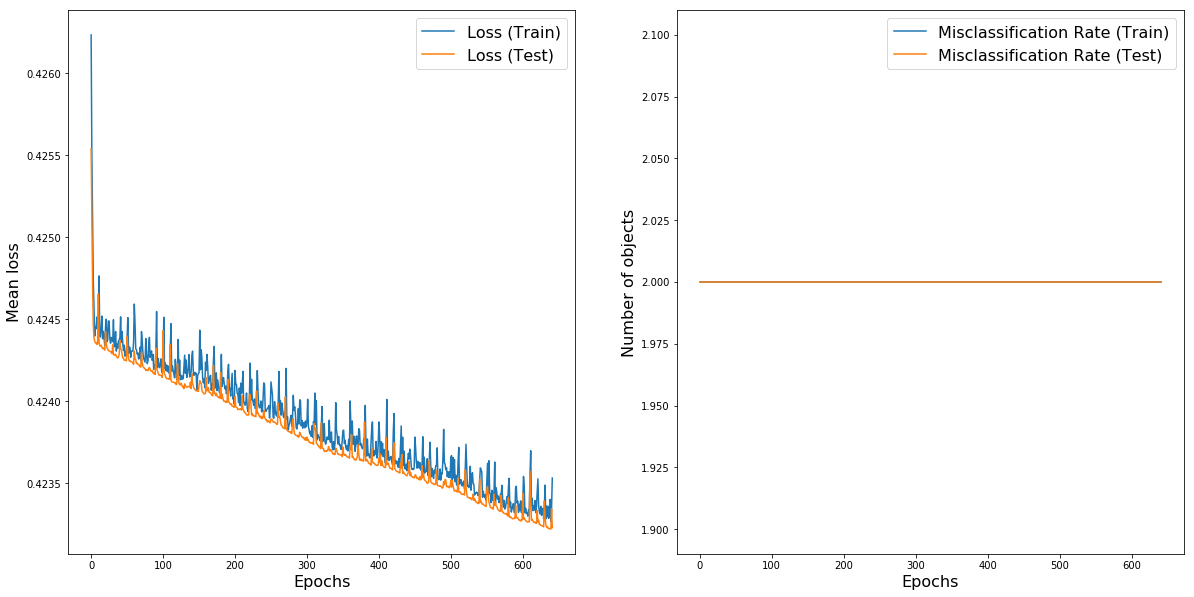

In [135]:
train_STOCH(net, learning_rate=0.00001, epochs=2000,
            dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test)

In [142]:
net_WITH_AUG = ClassifierAug_SMALL(32 * 32 * 3).cuda()

Epoch 101... Empirical Loss/Misclassification Rate (Train): nan/1014.000	 Empirical Loss/Misclassification Rate (Test): nan/1014.000000

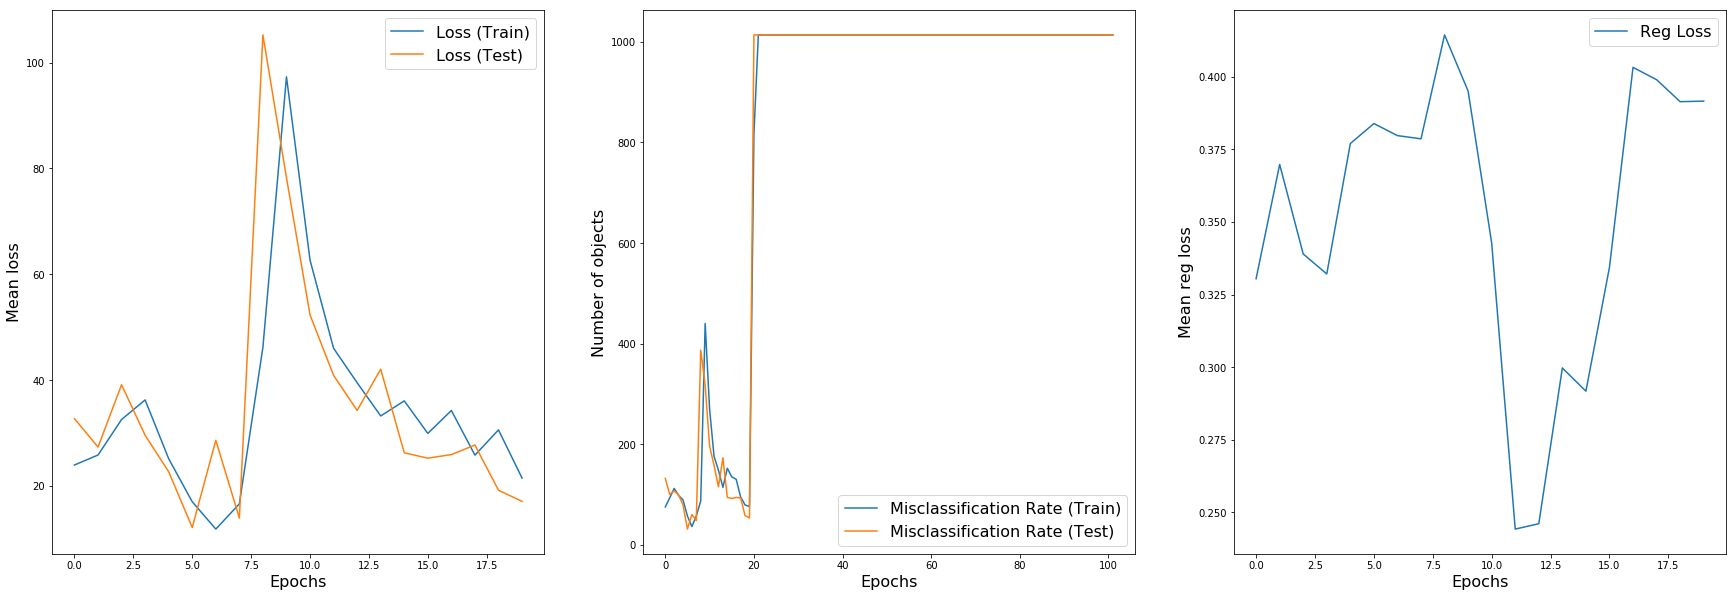

In [153]:
train_STOCH_WITH_AUG(net_WITH_AUG, learning_rate=0.003, reg_lambda=5, epochs=2000,
                     dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test)

In [64]:
def plot_img(im):
    rr = np.zeros([3, 32, 32])
    rr[0,:,:] = im[:1024].reshape(32, 32)
    rr[1,:,:] = im[1024:2048].reshape(32, 32)
    rr[2,:,:] = im[2048:].reshape(32, 32)
    rr = rr.transpose(1, 2, 0)
    plt.imshow(rr)